In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.clim_loss_vit import custom_loss
#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')


2025-03-24 09:42:01.934159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 09:42:02.233922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742827322.334772 3393129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742827322.364381 3393129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 09:42:02.634343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_tas_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_tas = xr.open_zarr(cmip6_tas_path)

cmip6_pr_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_pr = xr.open_zarr(cmip6_pr_path)
cmip6_lat = cmip6_pr.lat
cmip6_lon = cmip6_pr.lon

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_tas_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_tas = xr.open_mfdataset(gmfd_tas_files, combine='by_coords')
gmfd_pr_files = [f'{gmfd_data_path}/prcp_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_pr = xr.open_mfdataset(gmfd_pr_files, combine='by_coords')
gmfd_pr['prcp'] = gmfd_pr['prcp'] * 86400

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_tas.lat
target_lon = gmfd_tas.lon
cmip6_high_tas = cmip6_tas['tas'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_pr['pr'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_high_pr.where(cmip6_high_pr > 0, 0)  # Set negative values to zero
cmip6_high_pr = cmip6_high_pr * 86400
cmip6_high_psl = cmip6_psl['psl'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_high_tas['time'] = cmip6_high_tas['time'].dt.floor('D')
cmip6_high_pr['time'] = cmip6_high_pr['time'].dt.floor('D')

#### Load elevation

In [3]:
elev = xr.open_dataset('grids/elevation_0.25deg.nc')
elev_sub = elev.sel(latitude=slice(40.99986, 51.49986), longitude=slice( 6.69986, 30.99986 ))
elev_sub['elev'] = elev_sub['elev'].fillna(0) # convert NA to 0
elev_sub = elev_sub.rename({"latitude": "lat"})
elev_sub = elev_sub.rename({"longitude": "lon"})

elev_dif = elev_sub
# Check the new shape of 'elev'
elev_dif = elev_dif.squeeze(dim="z")



#### Transform (pr) and normalize

In [4]:
# Apply the log1p transformation to the 'prcp' variable
cmip6_high_pr_log1p = cmip6_high_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
cmip6_high_pr_log1p = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
   cmip6_high_pr,               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

# Apply the log1p transformation to the 'prcp' variable
gmfd_pr_log1p = gmfd_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
gmfd_pr_log1p['prcp'] = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
    gmfd_pr['prcp'],               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

In [5]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_tas_norm = normalize(cmip6_high_tas)
cmip6_psl_norm = normalize(cmip6_high_psl)
cmip6_pr_norm = normalize(cmip6_high_pr_log1p)
gmfd_tas_norm = normalize(gmfd_tas['tas'])
gmfd_pr_norm = normalize(gmfd_pr_log1p['prcp'])
elev_dif_norm = normalize(elev_dif['elev'])


# Convert data to NumPy arrays for use in Keras
cmip6_train_tas = cmip6_tas_norm.values
cmip6_train_psl = cmip6_psl_norm.values
cmip6_train_pr = cmip6_pr_norm.values
gmfd_train_pr = gmfd_pr_norm.values
gmfd_train_tas = gmfd_tas_norm.values
elev_dif_norm = elev_dif_norm.values

In [6]:
print(elev_dif_norm.shape)
print(gmfd_train_tas.shape)
elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], 23741, axis=0)
print(elev_dif_norm_final.shape)

(1, 42, 97)
(23741, 42, 97)
(23741, 42, 97)


0.0

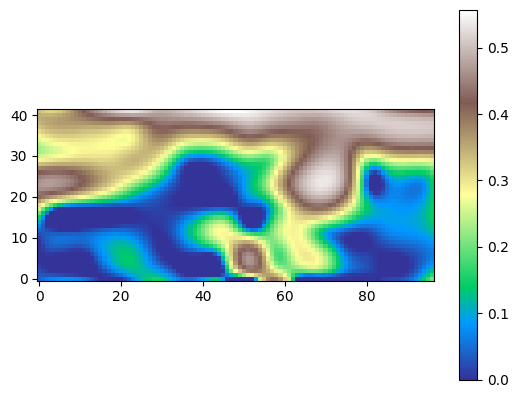

In [7]:
plt.imshow(cmip6_train_pr[10, :,:], origin='lower', cmap='terrain')
plt.colorbar()
cmip6_train_tas.min()

#### Compute residuals

In [8]:
import xarray as xr

res_tas = gmfd_train_tas  - cmip6_train_tas
res_pr = gmfd_train_pr  - cmip6_train_pr

-0.47014565645697814

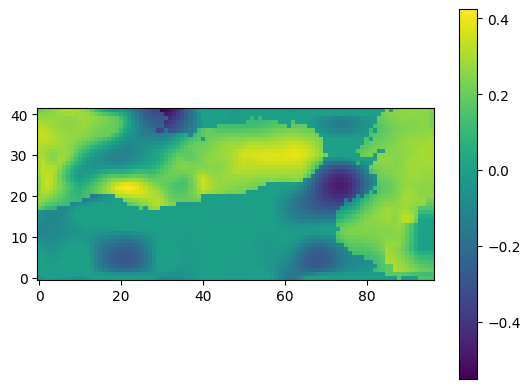

In [9]:
plt.imshow(res_pr[100, :,:], origin='lower', cmap='viridis')
plt.colorbar()
res_tas.min()

#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [10]:
import pandas as pd
index_2004 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [11]:
# Reshape data to add the channel dimension
cmip6_train_tas_reshaped = cmip6_train_tas[..., np.newaxis]
cmip6_train_pr_reshaped = cmip6_train_psl[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]
elev_dif_norm_reshaped = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_tas_reshaped,cmip6_train_pr_reshaped, cmip6_train_slp_reshaped, elev_dif_norm_reshaped), axis=-1)

gmfd_train_tas_reshaped = gmfd_train_tas[..., np.newaxis]
gmfd_train_pr_reshaped = gmfd_train_pr[..., np.newaxis]

gmfd_train_combined = np.concatenate((gmfd_train_tas_reshaped,gmfd_train_pr_reshaped), axis=-1)

res_tas_reshaped = res_tas[..., np.newaxis]
res_pr_reshaped = res_pr[..., np.newaxis]

res_train_combined = np.concatenate((res_tas_reshaped, res_pr_reshaped), axis=-1)

In [12]:
# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_combined[:index_2004]
res_train = res_train_combined[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_combined[index_2004:index_2009]
res_val = res_train_combined[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_combined[index_2009:]
res_test = res_train_combined[index_2009:]


# # Reshape X data to include the temporal dimension
# X_train = np.expand_dims(X_train, axis=1)
# X_val = np.expand_dims(X_val, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Reshape y data to include the temporal dimension
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# # Reshape y data to include the temporal dimension
# res_train = np.expand_dims(res_train, axis=1)
# res_val = np.expand_dims(res_val, axis=1)
# res_test = np.expand_dims(res_test, axis=1)


In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 42, 97, 4)
(1826, 42, 97, 4)
(1827, 42, 97, 4)
(20088, 42, 97, 2)
(1826, 42, 97, 2)
(1827, 42, 97, 2)


#### Create temporal sequences

In [14]:
def create_temporal_sequences_centered(data, window_size):
    total_seq_length = 2 * window_size + 1
    sequences = []
    
    # For all time points
    for i in range(len(data)):
        sequence = np.zeros((total_seq_length,) + data.shape[1:])
        
        # Handle past values
        for j in range(window_size):
            if i - j >= 0:  # If we have data for this past point
                sequence[window_size - j] = data[i - j]
            else:  # If we don't have data, use the earliest available
                sequence[window_size - j] = data[0]
        
        # Current value
        sequence[window_size] = data[i]
        
        # Handle future values
        for j in range(window_size):
            if i + j + 1 < len(data):  # If we have data for this future point
                sequence[window_size + j + 1] = data[i + j + 1]
            else:  # If we don't have data, use the last available
                sequence[window_size + j + 1] = data[-1]
        
        sequences.append(sequence)
    
    return np.array(sequences)

window_size = 3

In [15]:
X_train_seq = create_temporal_sequences_centered(X_train, window_size)  
X_val_seq = create_temporal_sequences_centered(X_val, window_size)      
X_test_seq = create_temporal_sequences_centered(X_test, window_size)     
y_train_seq = create_temporal_sequences_centered(y_train, window_size) 
y_val_seq = create_temporal_sequences_centered(y_val, window_size)     
y_test_seq = create_temporal_sequences_centered(y_test, window_size)   

res_train_seq = create_temporal_sequences_centered(res_train, window_size) 
res_val_seq = create_temporal_sequences_centered(res_val, window_size)     
res_test_seq = create_temporal_sequences_centered(res_test, window_size) 

print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_train shape:", y_train_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)
print("res_train_seq shape:", res_train_seq.shape)
print("res_val_seq shape:", res_val_seq.shape)

res_train_seq = res_train_seq.astype(np.float32)  # Add this line
res_val_seq = res_val_seq.astype(np.float32)    

X_train_seq = X_train_seq.astype(np.float32)  # Add this line
X_val_seq = X_val_seq.astype(np.float32)  
X_test_seq = X_test_seq.astype(np.float32)

del X_train
del X_val
del X_test
del y_train
del y_val
del y_test
del res_train
del res_val
del res_test

X_train_seq shape: (20088, 7, 42, 97, 4)
X_val_seq shape: (1826, 7, 42, 97, 4)
y_train shape: (20088, 7, 42, 97, 2)
y_val_seq shape: (1826, 7, 42, 97, 2)
res_train_seq shape: (20088, 7, 42, 97, 2)
res_val_seq shape: (1826, 7, 42, 97, 2)


#### Build the GAN (Keras with Tensofflow Backend)


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv3D, MaxPooling3D, Concatenate, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, TimeDistributed, Dropout, Embedding, Reshape, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from tqdm import tqdm

# Custom ResizeLayer for proper serialization (reuse from original GAN code)
@tf.keras.utils.register_keras_serializable()
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        channels = tf.shape(inputs)[-1]
        z_4d = tf.reshape(inputs, [-1, inputs.shape[2], inputs.shape[3], channels])
        z_resized = tf.image.resize(z_4d, size=[self.target_height, self.target_width], method='bilinear')
        return tf.reshape(z_resized, [batch_size, time_steps, self.target_height, self.target_width, channels])

    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({'target_height': self.target_height, 'target_width': self.target_width})
        return config

def unet_generator(time_steps=7, height=42, width=97, channels_input=4, channels_output=2, num_blocks=3, embedding_dim=32):
    # Inputs
    input_noisy_high_res = Input(shape=(time_steps, height, width, channels_output), name='noisy_high_res_input')
    input_low_res_cond = Input(shape=(time_steps, height, width, channels_input), name='low_res_cond_input')
    input_timestep = Input(shape=(1,), dtype=tf.int32, name='timestep_input')

    # Timestep embedding
    timestep_embedding = Embedding(1000, embedding_dim)(input_timestep)  # Shape: (batch, 1, embedding_dim)
    timestep_embedding = Dense(embedding_dim * 2, activation='relu')(timestep_embedding)  # Shape: (batch, 1, embedding_dim * 2)
    timestep_embedding = Dense(embedding_dim)(timestep_embedding)  # Shape: (batch, 1, embedding_dim)
    timestep_embedding = Reshape((1, 1, 1, embedding_dim))(timestep_embedding)  # Shape: (batch, 1, 1, 1, embedding_dim)

    # U-Net Architecture with Conditioning
    x_noisy = input_noisy_high_res
    x_cond = input_low_res_cond
    x = Concatenate(axis=-1)([x_noisy, x_cond])  # Shape: (batch, 7, 42, 97, channels_input + channels_output)

    skips = []
    # Downsampling path
    for i in range(num_blocks):
        filters = 64 * (2 ** i)
        x = Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(x)
        x = Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(x)

        # Project timestep embedding to match the number of filters
        projected_embedding = Dense(filters)(timestep_embedding)  # Shape: (batch, 1, 1, 1, filters)
        x = Add()([x, projected_embedding])  # Broadcasting happens here

        x = Dropout(0.2)(x)
        skips.append(x)
        x = MaxPooling3D((1, 2, 2))(x)

    # Bottleneck
    bottleneck_filters = 64 * (2 ** num_blocks)
    x = Conv3D(bottleneck_filters, (3, 3, 3), padding='same', activation='relu')(x)
    x = Conv3D(bottleneck_filters, (3, 3, 3), padding='same', activation='relu')(x)
    
    # Project and add timestep embedding in bottleneck
    projected_embedding = Dense(bottleneck_filters)(timestep_embedding)
    x = Add()([x, projected_embedding])
    
    x = Dropout(0.2)(x)

    # Upsampling path
    for i in range(num_blocks - 1, -1, -1):
        filters = 64 * (2 ** i)
        target_height = skips[i].shape[2]
        target_width = skips[i].shape[3]
        x = ResizeLayer(target_height, target_width)(x)
        x = Concatenate()([x, skips[i]])
        x = Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(x)
        x = Conv3D(filters, (3, 3, 3), padding='same', activation='relu')(x)
        
        # Project and add timestep embedding in upsampling
        projected_embedding = Dense(filters)(timestep_embedding)
        x = Add()([x, projected_embedding])
        
        x = Dropout(0.2)(x)

    # Output layer
    output_noise_prediction = Conv3D(channels_output, (1, 1, 1), padding='same', activation='linear', name='output_noise')(x)

    return Model(inputs=[input_noisy_high_res, input_low_res_cond, input_timestep], outputs=output_noise_prediction, name='unet_denoiser')

# CNN Discriminator (reused from original GAN code)
def cnn_2d(height, width, channels):
    input_2d = Input(shape=(height, width, channels))
    x = Conv2D(64, 3, strides=2, padding='same')(input_2d)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(1)(x)
    return Model(inputs=input_2d, outputs=output)

# Discriminator Model (reused from original GAN code)
def discriminator_model(time_steps=7, height=42, width=97, channels=2):
    input_disc = Input(shape=(time_steps, height, width, channels), name='input_disc')
    cnn = cnn_2d(height, width, channels)
    x = TimeDistributed(cnn)(input_disc)
    return Model(inputs=input_disc, outputs=x, name='discriminator')

In [17]:

# Gradient Penalty (reused from original GAN code)
def gradient_penalty(discriminator, real_images, generated_images, batch_size, gp_weight):
    alpha = tf.random.uniform([batch_size, 1, 1, 1, 1], 0.0, 1.0)
    interpolated = real_images + alpha * (generated_images - real_images)
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3, 4]) + 1e-8)
    gp = gp_weight * tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def noise_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return tf.linspace(beta_start, beta_end, timesteps)

# GAN-Diffusion Downscaler Model (Hybrid Model Class)
@tf.keras.utils.register_keras_serializable()
class GAN_Diffusion_Downscaler(tf.keras.Model):
    def __init__(self, denoiser, discriminator, timesteps=100, noise_schedule_fn=noise_schedule, **kwargs):
        super(GAN_Diffusion_Downscaler, self).__init__(**kwargs)
        self.denoiser = denoiser
        self.discriminator = discriminator
        self.timesteps = timesteps
        self.noise_schedule_fn = noise_schedule_fn
        self.beta_t = noise_schedule_fn(timesteps)
        self.alpha_t = 1. - self.beta_t
        self.alpha_cumprod_t = tf.math.cumprod(self.alpha_t, axis=0)

    def get_config(self):
        config = super(GAN_Diffusion_Downscaler, self).get_config()
        config.update({
            'denoiser_config': self.denoiser.get_config(), # Save denoiser config
            'discriminator_config': self.discriminator.get_config(), # Save discriminator config
            'timesteps': self.timesteps,
            'noise_schedule_fn_name': self.noise_schedule_fn.__name__ if hasattr(self.noise_schedule_fn, '__name__') else 'noise_schedule' # Save name, assuming it's noise_schedule function
        })
        return config

    @classmethod
    def from_config(cls, config):
        denoiser_config = config.pop('denoiser_config')
        discriminator_config = config.pop('discriminator_config')
        timesteps = config.pop('timesteps', 100) # Default value if not in config
        noise_schedule_fn_name = config.pop('noise_schedule_fn_name', 'noise_schedule')

        # Reconstruct denoiser and discriminator models from their configs
        denoiser = tf.keras.Model.from_config(denoiser_config)
        discriminator = tf.keras.Model.from_config(discriminator_config)

        # Reconstruct noise_schedule_fn - simple case, adjust if your function is more complex
        noise_schedule_fn_to_use = noise_schedule # Assuming noise_schedule is globally defined

        return cls(
            denoiser=denoiser,
            discriminator=discriminator,
            timesteps=timesteps,
            noise_schedule_fn=noise_schedule_fn_to_use,
            **config # Pass any remaining config items to the constructor
        )


    def compile(self, denoiser_optimizer, discriminator_optimizer, diffusion_loss_weight=1.0, gan_loss_weight=0.001, gp_weight=10.0, **kwargs):
        super(GAN_Diffusion_Downscaler, self).compile(**kwargs)
        self.denoiser_optimizer = denoiser_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.diffusion_loss_weight = diffusion_loss_weight
        self.gan_loss_weight = gan_loss_weight
        self.gp_weight = gp_weight


    @tf.function
    def train_step(self, data):
        low_res_input, high_res_target = data
        batch_size = tf.shape(high_res_target)[0]
        
        t = tf.random.uniform(shape=[batch_size], minval=0, maxval=self.timesteps, dtype=tf.int32)
        noise = tf.random.normal(shape=tf.shape(high_res_target))
        noisy_high_res_target = self.forward_diffusion_sample(high_res_target, t, noise)
    
        with tf.GradientTape() as disc_tape:
            noisy_input = tf.random.normal(shape=tf.shape(high_res_target))
            downscaled_output = self.reverse_diffusion_process(noisy_input, low_res_input)
            real_output_disc = self.discriminator(high_res_target, training=True)
            fake_output_disc = self.discriminator(downscaled_output, training=True)
            disc_loss = tf.reduce_mean(fake_output_disc) - tf.reduce_mean(real_output_disc)
            gp = gradient_penalty(self.discriminator, high_res_target, downscaled_output, batch_size, self.gp_weight)
            total_disc_loss = disc_loss + gp
        disc_grads = disc_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
    
        with tf.GradientTape() as denoiser_tape:
            t = tf.random.uniform(shape=[batch_size], minval=0, maxval=self.timesteps, dtype=tf.int32)
            noise = tf.random.normal(shape=tf.shape(high_res_target))
            noisy_high_res_target = self.forward_diffusion_sample(high_res_target, t, noise)
            predicted_noise = self.denoiser([noisy_high_res_target, low_res_input, tf.reshape(t, (-1, 1))], training=True)
            #tf.print("predicted_noise min:", tf.reduce_min(predicted_noise), "max:", tf.reduce_max(predicted_noise))
            diffusion_loss = tf.reduce_mean(tf.square(noise - predicted_noise))
            #tf.print("diffusion_loss:", diffusion_loss)
            downscaled_output_adv = self.reverse_diffusion_process_step(noisy_high_res_target, t, predicted_noise, low_res_input)
            fake_output_adv = self.discriminator(downscaled_output_adv, training=True)
            adversarial_loss = -tf.reduce_mean(fake_output_adv)
            total_denoiser_loss = self.diffusion_loss_weight * diffusion_loss + self.gan_loss_weight * adversarial_loss
        denoiser_grads = denoiser_tape.gradient(total_denoiser_loss, self.denoiser.trainable_variables)
        self.denoiser_optimizer.apply_gradients(zip(denoiser_grads, self.denoiser.trainable_variables))
    
        return {
            "denoiser_loss": total_denoiser_loss,
            "discriminator_loss": total_disc_loss,
            "diffusion_mse_loss": diffusion_loss,
            "gan_adversarial_loss": adversarial_loss
        }


    def forward_diffusion_sample(self, original_sample, timestep, noise=None):
        t = timestep
        if noise is None:
            noise = tf.random.normal(shape=tf.shape(original_sample))
        
        # Gather alpha_cumprod_t for the given timesteps
        alpha_cumprod_t = tf.gather(self.alpha_cumprod_t, indices=t)
        
        # Compute sqrt_alpha_cumprod and sqrt_one_minus_alpha_cumprod with explicit reshaping
        sqrt_alpha_cumprod = tf.sqrt(alpha_cumprod_t)[:, None, None, None, None]  # Shape: [32, 1, 1, 1, 1]
        sqrt_one_minus_alpha_cumprod = tf.sqrt(1.0 - alpha_cumprod_t)[:, None, None, None, None]  # Shape: [32, 1, 1, 1, 1]
        
        # Perform the multiplication and addition with broadcasting
        noisy_sample = sqrt_alpha_cumprod * original_sample + sqrt_one_minus_alpha_cumprod * noise
        return noisy_sample

    def reverse_diffusion_process_step(self, noisy_sample, timestep, predicted_noise, low_res_condition):
        t = timestep
        # Explicitly add dimensions to match [batch_size, 1, 1, 1, 1]
        alpha_t = tf.gather(self.alpha_t, indices=t)[:, None, None, None, None]  # Shape: [32, 1, 1, 1, 1]
        alpha_cumprod_t = tf.gather(self.alpha_cumprod_t, indices=t)[:, None, None, None, None]  # Shape: [32, 1, 1, 1, 1]
        beta_t = tf.gather(self.beta_t, indices=t)[:, None, None, None, None]  # Shape: [32, 1, 1, 1, 1]
    
        # Perform the computation with explicit broadcasting
        predicted_sample_direction = (1 / tf.sqrt(alpha_t)) * (noisy_sample - (beta_t / tf.sqrt(1. - alpha_cumprod_t)) * predicted_noise)
        
        # Rest of the method (if stochastic sampling is needed)
        variance_noise = tf.random.normal(shape=tf.shape(noisy_sample))
        sample_variance = self.get_variance(t)  # Assuming this returns a scalar or compatible tensor
        predicted_sample = predicted_sample_direction  # Add variance term if needed: + tf.sqrt(sample_variance) * variance_noise
        
        return predicted_sample

    def reverse_diffusion_process(self, initial_noise, low_res_condition):
        sample = initial_noise
        num_timesteps = self.timesteps  # Assuming timesteps is a class attribute
        for i in reversed(range(num_timesteps)): # Replaced with simple range loop
            # Replace the original line with this
            timestep_tensor = tf.fill([tf.shape(initial_noise)[0]], tf.constant(i, dtype=tf.int32))
            # Rest of your code
            predicted_noise = self.denoiser([sample, low_res_condition, tf.reshape(timestep_tensor, (-1, 1))])
            sample = self.reverse_diffusion_process_step(sample, timestep_tensor, predicted_noise, low_res_condition)
        return sample

    def get_variance(self, timestep): # Simplified variance schedule
        return 0.0 # Deterministic sampling


    def call(self, inputs):
        low_res_input = inputs
        # Construct the shape using tensor concatenation
        initial_noise_shape = tf.concat([tf.shape(inputs)[:-1], [self.denoiser.output_shape[-1]]], axis=0)
        initial_noise = tf.random.normal(initial_noise_shape)
        downscaled_output = self.reverse_diffusion_process(initial_noise, low_res_input)
        return downscaled_output
        
    

#### Train the model

In [18]:
print(X_train_seq.shape)

(20088, 7, 42, 97, 4)


In [19]:

generator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,  # Try reducing from your current value
    decay_steps=10000,
    decay_rate=0.9
)
discriminator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00003, # Example - reduce initial LR
    decay_steps=10000,
    decay_rate=0.9
)

# Build Models
denoiser = unet_generator( # Instantiate UNet denoiser
    time_steps=7,
    height=42,
    width=97,
    channels_input=4, # Adjust based on your low-res input channels
    channels_output=2, # Adjust based on your high-res output channels
    num_blocks=3
)
discriminator = discriminator_model( # Instantiate CNN discriminator
    time_steps=7,
    height=42,
    width=97,
    channels=2 # Match channels_output of denoiser
)

denoiser_optimizer = Adam(learning_rate=generator_lr_schedule, clipnorm=1.0, weight_decay=1e-5) # Example - add weight decay
discriminator_optimizer = Adam(learning_rate=discriminator_lr_schedule, clipnorm=1.0)


# Create and Compile GAN-Diffusion Downscaler
gan_diffusion_downscaler = GAN_Diffusion_Downscaler(denoiser=denoiser, discriminator=discriminator, timesteps=20) # Adjust timesteps as needed
gan_diffusion_downscaler.compile(
    denoiser_optimizer=denoiser_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    diffusion_loss_weight=1.0,
    gan_loss_weight=0.001,
    gp_weight=10.0
)

gan_diffusion_downscaler.summary() # Model Summary

I0000 00:00:1742827375.023149 3393129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:ae:00.0, compute capability: 8.9
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "gan__diffusion__downscaler"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ unet_denoiser (Functional)      │ (None, 7, 42, 97, 2)   │    23,430,882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Functional)      │ (None, 7, 1)           │     1,554,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,985,379 (95.31 MB)

 Trainable params: 24,983,587 (95.30 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
X_train_seq.shape

(20088, 7, 42, 97, 4)

In [ ]:

# --- Training Loop (Simplified - Adapt to your data) ---
batch_size = 32 # Adjust batch size
epochs = 1500 # Adjust epochs


n_train_samples = X_train_seq.shape[0]
n_val_samples = X_val_seq.shape[0]
steps_per_epoch = n_train_samples // batch_size
val_steps = n_val_samples // batch_size
patience = 10
best_val_mse = float('inf')
epochs_since_improvement = 0
checkpoint_dir = './models'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'gan_diffusion_downscaler_best.keras')


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step in range(steps_per_epoch):
        start_idx = step * batch_size
        end_idx = min(start_idx + batch_size, n_train_samples)
        input_batch_low_res = X_train_seq[start_idx:end_idx]
        real_batch_high_res = res_train_seq[start_idx:end_idx]
        losses = gan_diffusion_downscaler.train_step((input_batch_low_res, real_batch_high_res))
        if step % 100 == 0:
            print(f"Step {step}/{steps_per_epoch}: Denoiser Loss: {losses['denoiser_loss']:.4f}, Disc Loss: {losses['discriminator_loss']:.4f}, Diff MSE: {losses['diffusion_mse_loss']:.4f}, GAN Adv Loss: {losses['gan_adversarial_loss']:.4f}")
    

    # Validation (Simplified - Adapt for your needs)
    val_gen_loss = 0
    for val_step in range(val_steps):
        start_idx = val_step * batch_size
        end_idx = min(start_idx + batch_size, n_val_samples)
        val_input_batch_low_res = X_val_seq[start_idx:end_idx]
        val_real_batch_high_res = res_val_seq[start_idx:end_idx]
        val_generated = gan_diffusion_downscaler(val_input_batch_low_res, training=False) # Inference using call method
        val_gen_loss += tf.reduce_mean(tf.square(val_real_batch_high_res - val_generated))
    val_mse = val_gen_loss / val_steps
    print(f"Validation MSE: {val_mse:.4f}")


    # Checkpointing (reused from original GAN code)
    if val_mse < best_val_mse:
        print(f"Validation MSE improved from {best_val_mse:.4f} to {val_mse:.4f}. Saving model to {checkpoint_path}")
        best_val_mse = val_mse
        gan_diffusion_downscaler.save(checkpoint_path)
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        print(f"No improvement for {epochs_since_improvement} epochs")
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

print("Training finished!")

Epoch 1/1500


I0000 00:00:1742795639.175004  366921 cuda_dnn.cc:529] Loaded cuDNN version 90300


Step 0/627: Denoiser Loss: 1.0053, Disc Loss: 2.6344, Diff MSE: 1.0058, GAN Adv Loss: -0.5640
Step 100/627: Denoiser Loss: 0.3583, Disc Loss: -0.8099, Diff MSE: 0.3590, GAN Adv Loss: -0.6587
Step 200/627: Denoiser Loss: 0.2216, Disc Loss: -0.7557, Diff MSE: 0.2223, GAN Adv Loss: -0.6863
Step 300/627: Denoiser Loss: 0.1642, Disc Loss: -1.0451, Diff MSE: 0.1647, GAN Adv Loss: -0.5418
Step 400/627: Denoiser Loss: 0.1487, Disc Loss: -1.3395, Diff MSE: 0.1492, GAN Adv Loss: -0.4598
Step 500/627: Denoiser Loss: 0.1528, Disc Loss: -1.2055, Diff MSE: 0.1529, GAN Adv Loss: -0.0959
Step 600/627: Denoiser Loss: 0.1506, Disc Loss: -1.1672, Diff MSE: 0.1501, GAN Adv Loss: 0.4374
Validation MSE: 0.0483
Validation MSE improved from inf to 0.0483. Saving model to ./models/gan_diffusion_downscaler_best.keras
Epoch 2/1500
Step 0/627: Denoiser Loss: 0.1491, Disc Loss: -1.3538, Diff MSE: 0.1487, GAN Adv Loss: 0.4265
Step 100/627: Denoiser Loss: 0.1493, Disc Loss: -1.3446, Diff MSE: 0.1485, GAN Adv Loss: 0

#### Evaluate the model on validation data

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model
# model_saved = generator
# Load the model and evaluate

# Corrected custom_objects_load - refer to functions directly by name
#custom_objects_load = {'GAN': GAN, 'resize_function': resize_function, 'output_shape_lambda': output_shape_lambda} # Define custom objects for load
model_saved = tf.keras.models.load_model(
    'models/gan_diffusion_downscaler_best.keras'
)
print("Denoiser output_shape:", model_saved.denoiser.output_shape)



/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


Denoiser output_shape: (None, 7, 42, 97, 2)


In [21]:
# Get the mean and std from the training set for denormalization
cmip6_high_tas_min = cmip6_high_tas.min().values
cmip6_high_tas_max = cmip6_high_tas.max().values
cmip6_high_pr_min = cmip6_high_pr_log1p.min().values
cmip6_high_pr_max = cmip6_high_pr_log1p.max().values

# Get the mean and std from the training set for denormalization
gmfd_min_tas = gmfd_tas['tas'].min().values
gmfd_max_tas = gmfd_tas['tas'].max().values
gmfd_min_pr = gmfd_pr_log1p['prcp'].min().values
gmfd_max_pr = gmfd_pr_log1p['prcp'].max().values

In [23]:

y_pred = model_saved.predict(X_test_seq)

I0000 00:00:1742827450.648598 3393889 service.cc:148] XLA service 0x1532ac00e210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742827450.648914 3393889 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-24 09:44:10.922137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742827452.194219 3393889 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 09:44:15.028200: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-24 09:44:15.426748: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory t

58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step


In [24]:

# put back the residuals
y_pred_tas = X_test_seq[:,window_size,:,:,0] +  y_pred[:,window_size,:,:,0]
y_pred_pr = X_test_seq[:,window_size,:,:,1] +  y_pred[:,window_size,:,:,1]

print(y_pred.shape)
print(y_test_seq[:,window_size,:,:,0].shape)
# Back-transform the predictions for evaluation
y_test_denorm_tas = y_test_seq[:,window_size,:,:,0] * (gmfd_max_tas - gmfd_min_tas) + gmfd_min_tas
y_pred_denorm_tas = y_pred_tas * (cmip6_high_tas_max - cmip6_high_tas_min) + cmip6_high_tas_min

y_test_denorm_pr = y_test_seq[:,window_size,:,:,1] * (gmfd_max_pr - gmfd_min_pr) + gmfd_min_pr
y_pred_denorm_pr = y_pred_pr * (cmip6_high_pr_max - cmip6_high_pr_min) + cmip6_high_pr_min
# back transform from log1p
y_pred_denorm_pr_back = np.expm1(y_pred_denorm_pr)
y_test_denorm_pr_back = np.expm1(y_test_denorm_pr)
y_pred_denorm_pr_back[y_pred_denorm_pr_back < 0] = 0



(1827, 7, 42, 97, 2)
(1827, 42, 97)


In [25]:
##### import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf  # Import TensorFlow

def evaluate_and_plot(y_test_denorm, y_pred_denorm, title="Predicted vs Actual"):
    """
    Calculates RMSE, MAE, and correlation, and generates a scatter plot
    of predicted vs. actual values.

    Args:
        y_test_denorm (tf.Tensor): The actual/observed (denormalized) values (TensorFlow Tensor).
        y_pred_denorm (tf.Tensor): The predicted (denormalized) values (TensorFlow Tensor).
        title (str, optional): The title of the plot. Defaults to "Predicted vs Actual".
    """

    # Calculate RMSE, MAE, and correlation
    rmse = np.sqrt(mean_squared_error(tf.reshape(y_test_denorm, [-1]).numpy(), tf.reshape(y_pred_denorm, [-1]).numpy())) # Use tf.reshape and .numpy()
    mae = mean_absolute_error(tf.reshape(y_test_denorm, [-1]).numpy(), tf.reshape(y_pred_denorm, [-1]).numpy())   # Use tf.reshape and .numpy()
    correlation = np.corrcoef(tf.reshape(y_test_denorm, [-1]).numpy(), tf.reshape(y_pred_denorm, [-1]).numpy())[0,1] # Use tf.reshape and .numpy()

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
    plt.scatter(tf.reshape(y_test_denorm, [-1]).numpy(), tf.reshape(y_pred_denorm, [-1]).numpy(), alpha=0.5) # Use tf.reshape and .numpy()
    plt.xlabel('Actual Values (GMFD)')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} (Back-transformed)')
    plt.plot([tf.reduce_min(y_test_denorm).numpy(), tf.reduce_max(y_test_denorm).numpy()], # Use tf.reduce_min/max and .numpy()
            [tf.reduce_min(y_test_denorm).numpy(), tf.reduce_max(y_test_denorm).numpy()], 'r--') # Use tf.reduce_min/max and .numpy()

    # Add RMSE, MAE, and correlation text to the upper left
    plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()


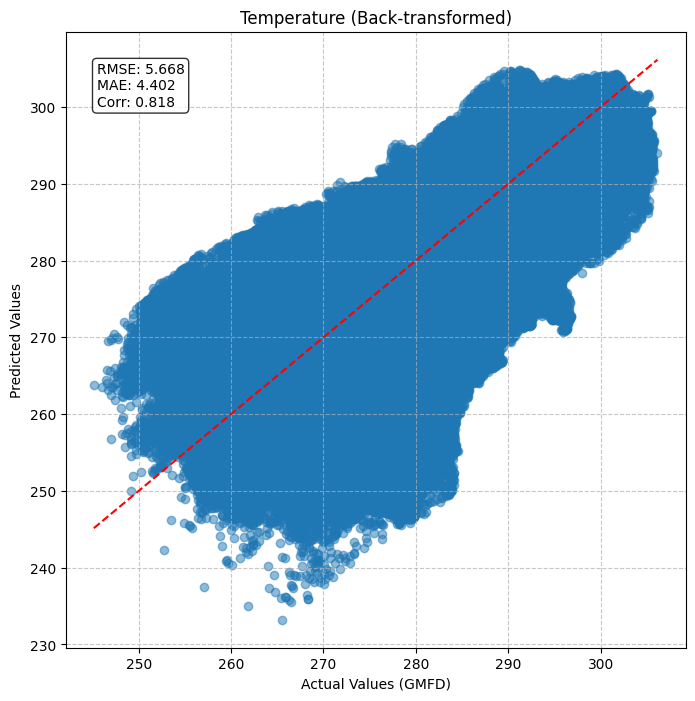

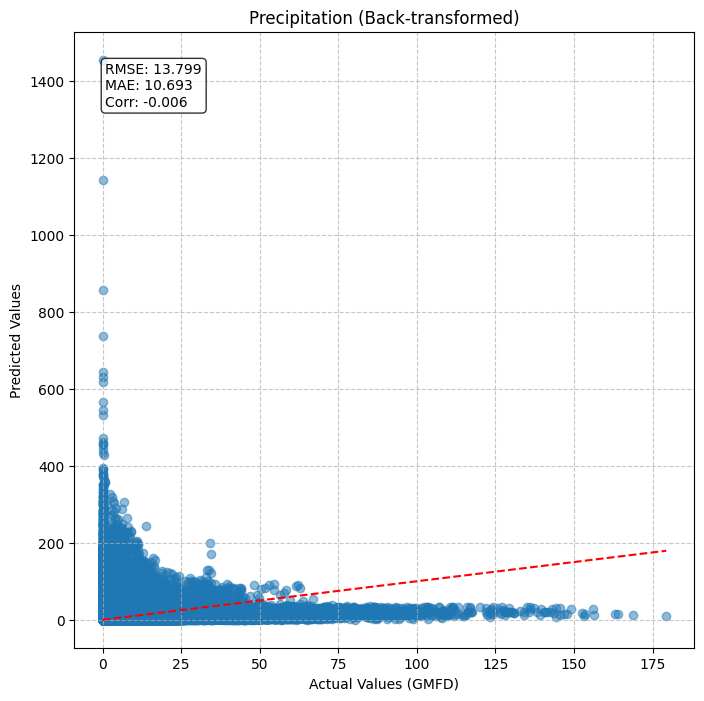

In [26]:
evaluate_and_plot(y_test_denorm_tas, y_pred_denorm_tas, title="Temperature")
evaluate_and_plot(y_test_denorm_pr_back, y_pred_denorm_pr_back, title="Precipitation")

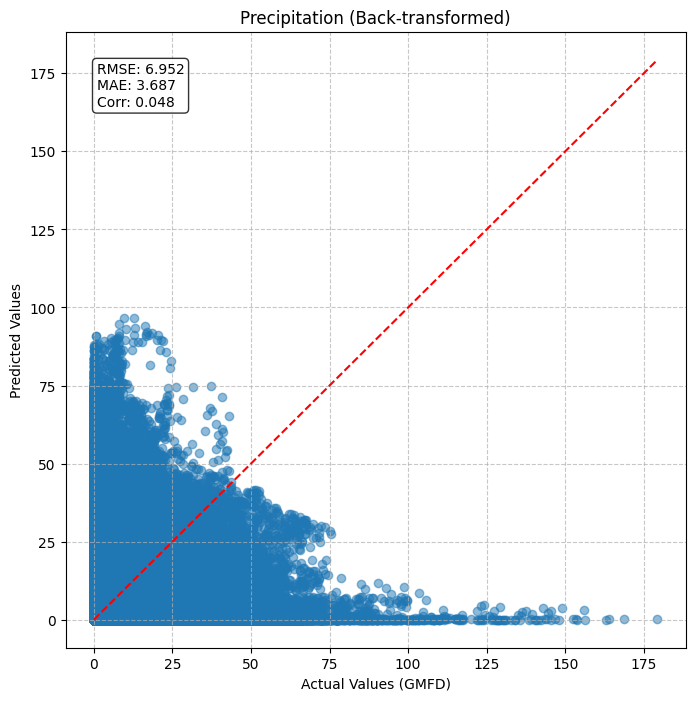

In [57]:
evaluate_and_plot( gmfd_pr['prcp'].values[index_2009:], cmip6_high_pr.values[index_2009:], title="Precipitation")

#### Train the on All Data
Train the model on all the data (no splitting)

In [ ]:
X_all = np.concatenate((X_train_seq, X_val_seq, X_test_seq), axis=0)
y_all = np.concatenate((y_train_seq, y_val_seq, y_test_seq), axis=0)
res_all = np.concatenate((res_train_seq, res_val_seq, res_test_seq), axis=0)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau

# --- Hyperparameters ---
epochs = 500
batch_size = 100
weight_decay = 0.01
lambda_gp = 10  # Gradient penalty weight

# --- Model Setup ---
input_shape = (7, 42, 97, 4)  # Low-resolution input dimensions
residual_shape = (7, 42, 97, 2)  # High-resolution residual dimensions
patch_size = (7, 7, 7)

# Instantiate generator and discriminator (assuming these are defined elsewhere and you've made the suggested architectural changes)
model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=320,
    num_heads=10,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.2,
    weight_decay=weight_decay
)

discriminator = discriminator_model(
    input_shape=residual_shape
)  # Discriminator should match residual shape and have NO sigmoid at the output

# --- Optimizers ---
g_optimizer = AdamW(learning_rate=1e-4, weight_decay=weight_decay)
d_optimizer = AdamW(learning_rate=5e-5, weight_decay=weight_decay)  # Lower discriminator LR

# --- Loss Functions (Wasserstein Loss) ---
def generator_loss_fn(fake_output):
    # We want the generator to create outputs that the discriminator classifies as real,
    # so we want to maximize D(fake), which is equivalent to minimizing -D(fake).
    return -tf.reduce_mean(fake_output)

def discriminator_loss_fn(real_output, fake_output):
    # We want the discriminator to output high scores for real images and low scores for fake images.
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# --- Gradient Penalty ---
def gradient_penalty(real_samples, fake_samples, discriminator):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weighted average between real and fake samples
    alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1, 1, 1], minval=0., maxval=1.)
    interpolated_samples = (alpha * real_samples) + ((1 - alpha) * fake_samples)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_samples)
        # 1. Get the discriminator output for this interpolated sample.
        pred = discriminator(interpolated_samples, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated sample.
    grads = gp_tape.gradient(pred, [interpolated_samples])[0]

    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3, 4]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

# --- GAN Class (Modified for WGAN-GP) ---
@keras.saving.register_keras_serializable()
class WGAN(Model):
    def __init__(self, generator, discriminator, **kwargs):
        # Remove lambda_gp from kwargs before passing it to super().__init__()
        lambda_gp = kwargs.pop('lambda_gp') 
        super(WGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp  # Store it as an attribute of the class

    def compile(
        self,
        generator_optimizer,
        discriminator_optimizer,
        generator_loss_fn,
        discriminator_loss_fn,
    ):
        super(WGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss_fn = generator_loss_fn
        self.discriminator_loss_fn = discriminator_loss_fn

    @tf.function(jit_compile=True)
    def train_step(self, data):
        # Unpack the data
        input_lr, real_images = data

        # 1. Train the discriminator
        for _ in range(5):  # Train the discriminator more than the generator (e.g., 5 times)
            with tf.GradientTape() as disc_tape:
                # Generate high-resolution images from low-resolution input
                generated_images = self.generator(input_lr, training=True)

                # Get discriminator outputs for real and fake images
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(generated_images, training=True)

                # Calculate the discriminator loss
                disc_loss = self.discriminator_loss_fn(real_output, fake_output)

                # Calculate the gradient penalty
                gp = gradient_penalty(real_images, generated_images, self.discriminator)

                # Add the gradient penalty to the total discriminator loss
                total_disc_loss = disc_loss + self.lambda_gp * gp

            # Compute discriminator gradients
            discriminator_gradients = disc_tape.gradient(
                total_disc_loss, self.discriminator.trainable_variables
            )

            # Apply discriminator updates
            self.discriminator_optimizer.apply_gradients(
                zip(discriminator_gradients, self.discriminator.trainable_variables)
            )

        # 2. Train the generator
        with tf.GradientTape() as gen_tape:
            # Generate high-resolution images from low-resolution input
            generated_images = self.generator(input_lr, training=True)

            # Get discriminator output for generated images (we want them to "fool" the discriminator)
            fake_output = self.discriminator(generated_images, training=True)

            # Calculate the generator loss (maximize D(fake), which is the same as minimizing -D(fake))
            gen_loss = self.generator_loss_fn(fake_output)

        # Compute generator gradients
        generator_gradients = gen_tape.gradient(
            gen_loss, self.generator.trainable_variables
        )

        # Apply generator updates
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )

        return {
            "generator_loss": gen_loss,
            "discriminator_loss": total_disc_loss,
            "gradient_penalty": gp
        }

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "generator": self.generator,
                "discriminator": self.discriminator,
                "lambda_gp": self.lambda_gp, # Add lambda_gp to the config
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        # Create a new dictionary for the config without 'lambda_gp'
        new_config = {k: v for k, v in config.items() if k != 'lambda_gp'}
        # Create the instance using the modified config
        instance = cls(**new_config)
        # Set lambda_gp separately
        instance.lambda_gp = config['lambda_gp']
        return instance
    

    def call(self, inputs, training=False):
        return self.generator(inputs, training=training)

# Create the WGAN object
wgan = WGAN(generator=model, discriminator=discriminator, lambda_gp=lambda_gp)

# Compile the WGAN
wgan.compile(
    generator_optimizer=g_optimizer,
    discriminator_optimizer=d_optimizer,
    generator_loss_fn=generator_loss_fn,
    discriminator_loss_fn=discriminator_loss_fn,
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(
        monitor="val_content_loss",
        patience=8,  # Reduced patience
        restore_best_weights=True,
        min_delta=5e-4,
        mode="min",
    ),
    ModelCheckpoint(
        filepath="models/gan_generator_best.keras",
        monitor="val_content_loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1,
    ),
    TerminateOnNaN(),
    ReduceLROnPlateau(
        monitor='val_content_loss',
        factor=0.6,  # More gradual reduction
        patience=8,  # Increased patience
        min_lr=1e-6,
        verbose=1
    )
]

# --- Set the model for each callback ---
for callback in callbacks:
    if isinstance(callback, tf.keras.callbacks.ModelCheckpoint):
        callback.set_model(model)  # Use the generator model for checkpointing
    else:
        callback.set_model(wgan)  # Use the WGAN model

# --- Call on_train_begin for each callback ---
for callback in callbacks:
    callback.on_train_begin()

# --- Training Loop ---
g_losses, d_losses, val_content_losses, gp_values = [], [], [], [] # Added list to store gradient penalty values

for epoch in range(epochs):
    epoch_g_loss, epoch_d_loss, epoch_gp = 0, 0, 0 # Added variable to track gradient penalty

    for step in range(X_train_seq.shape[0] // batch_size):
        # Select a random batch of data
        idx = np.random.randint(0, X_train_seq.shape[0], batch_size)
        input_lr = X_train_seq[idx]  # Low-resolution input (CMIP6)
        input_hr = res_train_seq[idx]  # High-resolution target (residuals)

        # Training step
        losses = wgan.train_step((input_lr, input_hr))
        gen_loss = losses["generator_loss"]
        disc_loss = losses["discriminator_loss"]
        gp = losses["gradient_penalty"]

        epoch_g_loss += gen_loss
        epoch_d_loss += disc_loss
        epoch_gp += gp

    # Compute average losses for the epoch
    avg_gen_loss = epoch_g_loss / (X_train_seq.shape[0] // batch_size)
    avg_disc_loss = epoch_d_loss / (X_train_seq.shape[0] // batch_size)
    avg_gp = epoch_gp / (X_train_seq.shape[0] // batch_size)
    g_losses.append(avg_gen_loss)
    d_losses.append(avg_disc_loss)
    gp_values.append(avg_gp)

    # Print epoch losses
    print(
        f"Epoch {epoch + 1}/{epochs} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}, Gradient Penalty: {avg_gp:.4f}"
    )

    # Validation (every 3 epochs)
    if epoch % 3 == 0:
        val_losses = []
        for val_step in range(X_val_seq.shape[0] // batch_size):
            idx_val = np.random.randint(0, X_val_seq.shape[0], batch_size)
            input_lr_val = X_val_seq[idx_val]
            input_hr_val = res_val_seq[idx_val]

            # Generate high-resolution data
            generated_hr_val = wgan.generator(input_lr_val, training=False)

            # Calculate content loss (e.g., MSE between generated and target residuals)
            val_content_loss = tf.reduce_mean(tf.square(input_hr_val - generated_hr_val))
            val_losses.append(val_content_loss.numpy())

        avg_val_loss = np.mean(val_losses)
        val_content_losses.append(avg_val_loss)
        print(f"Validation Content Loss: {avg_val_loss:.4f}")

        # Execute callbacks
        logs = {"val_content_loss": avg_val_loss}
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs)

## Make prediction

In [30]:
from keras.models import load_model
model_saved = load_model('models/gan_diffusion_downscaler_best.keras')

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


### Historical

In [27]:
# Load the CMIP6 raw data (predictor variables)
cmip6_historical = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical = xr.open_zarr(cmip6_historical)
cmip6_historical_high_res = cmip6_historical.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_historical_tas_min = cmip6_historical_high_res['tas'].min().values
cmip6_historical_tas_max = cmip6_historical_high_res['tas'].max().values
cmip6_historical_norm = normalize(cmip6_historical_high_res['tas'])
cmip6_historical_norm = cmip6_historical_norm.values
cmip6_historical_norm_reshaped = cmip6_historical_norm[..., np.newaxis]


cmip6_historical_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_pr = xr.open_zarr(cmip6_historical_pr)
cmip6_historical_pr = cmip6_historical_pr * 86400
cmip6_historical_pr_high_res = cmip6_historical_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_pr_high_res['pr'] = xr.where(cmip6_historical_pr_high_res['pr'] < 0, 0, cmip6_historical_pr_high_res['pr'])

cmip6_historical_pr_high_res_log1p = cmip6_historical_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_historical_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_historical_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_historical_pr_min = cmip6_historical_pr_high_res_log1p['pr'].min().values
cmip6_historical_pr_max = cmip6_historical_pr_high_res_log1p['pr'].max().values

cmip6_historical_pr_norm_log1p = normalize(cmip6_historical_pr_high_res_log1p ['pr'])
cmip6_historical_pr_norm_log1p = cmip6_historical_pr_norm_log1p.values
cmip6_historical_pr_norm_log1p_reshaped = cmip6_historical_pr_norm_log1p[..., np.newaxis]

cmip6_historical_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_psl = xr.open_zarr(cmip6_historical_psl)
cmip6_historical_psl_high_res = cmip6_historical_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_psl_norm = normalize(cmip6_historical_psl_high_res['psl'])
cmip6_historical_psl_norm = cmip6_historical_psl_norm.values
cmip6_historical_psl_norm_reshaped = cmip6_historical_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_historical_norm_reshaped), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_historical_norm_reshaped, cmip6_historical_pr_norm_log1p_reshaped, cmip6_historical_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [28]:
print(X_scen.shape)

(23741, 7, 42, 97, 4)


In [ ]:
import numpy as np

# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
num_splits = 5  # Number of splits
split_size = num_samples // num_splits  # Integer division to get the size of each split

# List to store predictions
predicted_splits = []

# Split the dataset and perform predictions
for i in range(num_splits):
    start_idx = i * split_size
    # For the last split, include the remainder
    end_idx = start_idx + split_size if i < num_splits - 1 else num_samples
    split = X_scen[start_idx:end_idx]
    
    # Perform prediction on the split
    predicted_split = model_saved.predict(split)
    predicted_splits.append(predicted_split)

# Concatenate the predictions
predicted_high_res = np.concatenate(predicted_splits, axis=0)

print(predicted_high_res.shape)

149/149 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step
132/149 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step

In [ ]:

# temperature
predicted_high_res_tas = cmip6_historical_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_historical_tas_max- cmip6_historical_tas_min) + cmip6_historical_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_historical_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_historical_pr_max - cmip6_historical_pr_min) + cmip6_historical_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


### Scenario data

#### SSP 126

In [21]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp126 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp126 = xr.open_zarr(cmip6_ssp126)
cmip6_sp126_high_res = cmip6_ssp126.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp126_tas_min = cmip6_sp126_high_res['tas'].min().values
cmip6_sp126_tas_max = cmip6_sp126_high_res['tas'].max().values
cmip6_sp126_norm = normalize(cmip6_sp126_high_res['tas'])
cmip6_sp126_norm = cmip6_sp126_norm.values
cmip6_sp126_norm_reshaped = cmip6_sp126_norm[..., np.newaxis]


cmip6_sp126_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_pr = xr.open_zarr(cmip6_sp126_pr)
cmip6_sp126_pr = cmip6_sp126_pr * 86400
cmip6_sp126_pr_high_res = cmip6_sp126_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_pr_high_res['pr'] = xr.where(cmip6_sp126_pr_high_res['pr'] < 0, 0, cmip6_sp126_pr_high_res['pr'])

cmip6_sp126_pr_high_res_log1p = cmip6_sp126_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp126_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp126_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp126_pr_min = cmip6_sp126_pr_high_res_log1p['pr'].min().values
cmip6_sp126_pr_max = cmip6_sp126_pr_high_res_log1p['pr'].max().values

cmip6_sp126_pr_norm_log1p = normalize(cmip6_sp126_pr_high_res_log1p ['pr'])
cmip6_sp126_pr_norm_log1p = cmip6_sp126_pr_norm_log1p.values
cmip6_sp126_pr_norm_log1p_reshaped = cmip6_sp126_pr_norm_log1p[..., np.newaxis]

cmip6_sp126_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_psl = xr.open_zarr(cmip6_sp126_psl)
cmip6_sp126_psl_high_res = cmip6_sp126_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_psl_norm = normalize(cmip6_sp126_psl_high_res['psl'])
cmip6_sp126_psl_norm = cmip6_sp126_psl_norm.values
cmip6_sp126_psl_norm_reshaped = cmip6_sp126_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp126_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp126_norm_reshaped, cmip6_sp126_pr_norm_log1p_reshaped, cmip6_sp126_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [22]:
import numpy as np

# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
num_splits = 8  # Number of splits
split_size = num_samples // num_splits  # Integer division to get the size of each split

# List to store predictions
predicted_splits = []

# Split the dataset and perform predictions
for i in range(num_splits):
    start_idx = i * split_size
    # For the last split, include the remainder
    end_idx = start_idx + split_size if i < num_splits - 1 else num_samples
    split = X_scen[start_idx:end_idx]
    
    # Perform prediction on the split
    predicted_split = model_saved.predict(split)
    predicted_splits.append(predicted_split)

# Concatenate the predictions
predicted_high_res = np.concatenate(predicted_splits, axis=0)

print(predicted_high_res.shape)

I0000 00:00:1741976232.773393 2530803 service.cc:148] XLA service 0x14fef801aa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741976232.773430 2530803 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-14 13:17:12.791103: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741976232.910936 2530803 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-14 13:17:16.138512: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,128,7,42,97]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,7,42,97]{4,3,2,1,0}, f32[128,128,3,3,3]{4,3,2,1,0}, f32[128]{0}, f32[32,128,7,42,97]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend

  2/123 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step

I0000 00:00:1741976236.907394 2530803 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step
(31411, 7, 42, 97, 4)


In [23]:

# temperature
predicted_high_res_tas = cmip6_sp126_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp126_tas_max- cmip6_sp126_tas_min) + cmip6_sp126_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp126_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp126_pr_max - cmip6_sp126_pr_min) + cmip6_sp126_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


In [ ]:
predicted_high_res_denorm[predicted_high_res_denorm < 0] = 0
predicted_high_res_denorm.min()

In [ ]:
predicted_pr.isel(time=5000).plot() 

In [ ]:
gmfd_pr['prcp'].isel(time=5000).plot() # Use .compute() if using Dask

In [ ]:
cmip6_sp126_pr['pr'].isel(time=5000).plot()  # Use .compute() if using Dask

#### SSP 245

In [ ]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_tas_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_tas_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm = cmip6_sp245_norm.values
cmip6_sp245_norm_reshaped = cmip6_sp245_norm[..., np.newaxis]


cmip6_sp245_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_pr = xr.open_zarr(cmip6_sp245_pr)
cmip6_sp245_pr = cmip6_sp245_pr * 86400
cmip6_sp245_pr_high_res = cmip6_sp245_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_pr_high_res['pr'] = xr.where(cmip6_sp245_pr_high_res['pr'] < 0, 0, cmip6_sp245_pr_high_res['pr'])

cmip6_sp245_pr_high_res_log1p = cmip6_sp245_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp245_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp245_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp245_pr_min = cmip6_sp245_pr_high_res_log1p['pr'].min().values
cmip6_sp245_pr_max = cmip6_sp245_pr_high_res_log1p['pr'].max().values

cmip6_sp245_pr_norm_log1p = normalize(cmip6_sp245_pr_high_res_log1p ['pr'])
cmip6_sp245_pr_norm_log1p = cmip6_sp245_pr_norm_log1p.values
cmip6_sp245_pr_norm_log1p_reshaped = cmip6_sp245_pr_norm_log1p[..., np.newaxis]

cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_norm = cmip6_sp245_psl_norm.values
cmip6_sp245_psl_norm_reshaped = cmip6_sp245_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp245_psl_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_pr_norm_log1p_reshaped, cmip6_sp245_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [ ]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)

In [ ]:
# temperature
predicted_high_res_tas = cmip6_sp245_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp245_tas_max- cmip6_sp245_tas_min) + cmip6_sp245_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp245_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp245_pr_max - cmip6_sp245_pr_min) + cmip6_sp245_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


#### SSP 585

In [ ]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp585 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp585 = xr.open_zarr(cmip6_ssp585)
cmip6_sp585_high_res = cmip6_ssp585.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp585_tas_min = cmip6_sp585_high_res['tas'].min().values
cmip6_sp585_tas_max = cmip6_sp585_high_res['tas'].max().values
cmip6_sp585_norm = normalize(cmip6_sp585_high_res['tas'])
cmip6_sp585_norm = cmip6_sp585_norm.values
cmip6_sp585_norm_reshaped = cmip6_sp585_norm[..., np.newaxis]


cmip6_sp585_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_pr = xr.open_zarr(cmip6_sp585_pr)
cmip6_sp585_pr = cmip6_sp585_pr * 86400
cmip6_sp585_pr_high_res = cmip6_sp585_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_pr_high_res['pr'] = xr.where(cmip6_sp585_pr_high_res['pr'] < 0, 0, cmip6_sp585_pr_high_res['pr'])

cmip6_sp585_pr_high_res_log1p = cmip6_sp585_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp585_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp585_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp585_pr_min = cmip6_sp585_pr_high_res_log1p['pr'].min().values
cmip6_sp585_pr_max = cmip6_sp585_pr_high_res_log1p['pr'].max().values

cmip6_sp585_pr_norm_log1p = normalize(cmip6_sp585_pr_high_res_log1p ['pr'])
cmip6_sp585_pr_norm_log1p = cmip6_sp585_pr_norm_log1p.values
cmip6_sp585_pr_norm_log1p_reshaped = cmip6_sp585_pr_norm_log1p[..., np.newaxis]

cmip6_sp585_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_psl = xr.open_zarr(cmip6_sp585_psl)
cmip6_sp585_psl_high_res = cmip6_sp585_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_psl_norm = normalize(cmip6_sp585_psl_high_res['psl'])
cmip6_sp585_psl_norm = cmip6_sp585_psl_norm.values
cmip6_sp585_psl_norm_reshaped = cmip6_sp585_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp585_psl_norm), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp585_norm_reshaped, cmip6_sp585_pr_norm_log1p_reshaped, cmip6_sp585_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [ ]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)


# temperature
predicted_high_res_tas = cmip6_sp585_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp585_tas_max- cmip6_sp585_tas_min) + cmip6_sp585_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp585_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp585_pr_max - cmip6_sp585_pr_min) + cmip6_sp585_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")
